<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/MultimodalRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal RAG
building multimodal RAG from a conceptual prospective

https://colab.research.google.com/drive/1sVWzo_7iKAyXl1lLTXYE18bIWOkAcJiC?usp=sharing#scrollTo=g9JyFSCBhzV7
https://github.com/google-gemini/cookbook/blob/main/quickstarts/Audio.ipynb
https://huggingface.co/docs/transformers/en/model_doc/speech_to_text
https://huggingface.co/openai/clip-vit-base-patch16
https://ai.google.dev/api/python/google/generativeai/GenerativeModel

# make an API key
https://aistudio.google.com/app/apikey


# Setup

In [1]:
!pip install pydub

In [2]:
import os
import google.generativeai as genai
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GeminiAPIKey')
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

# Getting Multimodal Data

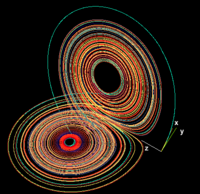

In [58]:
import requests
from PIL import Image
from IPython.display import display
import os

# Loading image
url = 'https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Multimodal/MMRAG/Lorenz_Ro28-200px.png?raw=true'
response = requests.get(url, stream=True)
image = Image.open(response.raw).convert('RGB')

# Save the image locally as JPG
save_path = 'image.jpg'
image.save(save_path, 'JPEG')
display(image)

Sampling rate: 16000 Hz


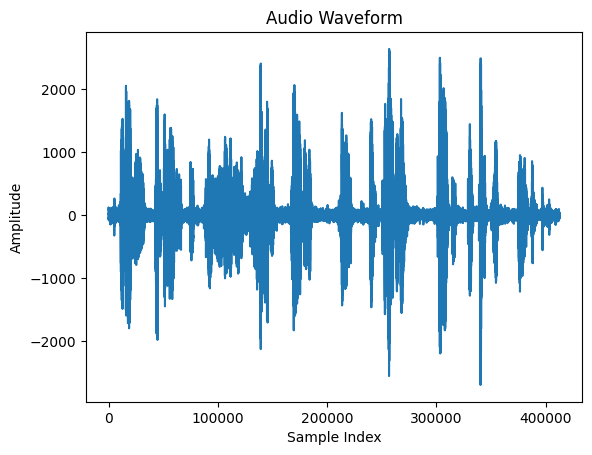

In [5]:
"""Downloading audio waveform from multimodal dataset
"""

from pydub import AudioSegment
import numpy as np
import io
import matplotlib.pyplot as plt
import wave
import requests

# Downloading audio file
url = "https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Multimodal/MMRAG/audio.mp3?raw=true"
response = requests.get(url)
audio_data = io.BytesIO(response.content)

# Converting to wav and loading
audio_segment = AudioSegment.from_file(audio_data, format="mp3")

# Downsampling to 16000 Hz
 #(this is necessary because a future model requires it to be at 16000Hz)
sampling_rate = 16000
audio_segment = audio_segment.set_frame_rate(sampling_rate)

# Exporting the downsampled audio to a wav file in memory
wav_data = io.BytesIO()
audio_segment.export(wav_data, format="wav")
wav_data.seek(0)  # Back to beginning of IO for reading
wav_file = wave.open(wav_data, 'rb')

# converting the audio data to a numpy array
frames = wav_file.readframes(-1)
audio_waveform = np.frombuffer(frames, dtype=np.int16).astype(np.float32)

# Rendering audio waveform
plt.plot(audio_waveform)
plt.title("Audio Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

In [59]:
"""Downloading text from multimodal dataset
"""

import requests

# URL of the text file
url = "https://github.com/DanielWarfield1/MLWritingAndResearch/blob/main/Assets/Multimodal/MMRAG/Wiki.txt?raw=true"
response = requests.get(url)
text_data = response.text

# truncating length for compatability with an encoder that accepts a small context
# a different encoder could be used which allows for larger context lengths
text_data = text_data[:300]

print(text_data)

All Quiet on the Western Front (German: Im Westen nichts Neues, lit. 'In the West, nothing new') is a semi-autobiographical novel by Erich Maria Remarque, a German veteran of World War I. The book describes the German soldiers' extreme physical and mental trauma during the war as well as the detachm


# Grounding Audio in Text
It's hard to find a multimodal model embedding that understands audio, so I'm grounding the audio in text via a speech to text model.

In [7]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

#the model that generates text based on speech audio
model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-medium-librispeech-asr")
#a processor that gets everything set up
processor = Speech2TextProcessor.from_pretrained("facebook/s2t-medium-librispeech-asr")

#passing through model
inputs = processor(audio_waveform, sampling_rate=sampling_rate, return_tensors="pt")
generated_ids = model.generate(inputs["input_features"], attention_mask=inputs["attention_mask"])

#turning model output into text
audio_transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

audio_transcription

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of Speech2TextForConditionalGeneration were not initialized from the model checkpoint at facebook/s2t-medium-librispeech-asr and are newly initialized: ['model.decoder.embed_positions.weights', 'model.encoder.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"i recorded a more complex audiophile but i'm going to re record with a simpler one because it was surprisingly difficult my favorite harpist is trulo o'curlon toloh now torqualate iowa torqua"

# Definign Query

In [46]:
query = 'who is my favorite harpist?'

# Embedding Data
Using a clip style model, which can embed images and text, to embed the image, text, and audio grounded in text.

In [62]:
from transformers import CLIPProcessor, CLIPModel

# Load the model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Encode the image
inputs = processor(images=image, return_tensors="pt")
image_embeddings = model.get_image_features(**inputs)

# Encode the text
inputs = processor(text=[query, audio_transcription, text_data], return_tensors="pt", padding=True)
text_embeddings = model.get_text_features(**inputs)

# Print or use the embeddings
print("Image Embeddings:", image_embeddings)
print("Text Embeddings:", text_embeddings)

Image Embeddings: tensor([[-5.2262e-02, -3.3041e-01,  2.2335e-01, -7.3059e-02, -1.5052e-01,
         -5.1145e-02, -9.7562e-02,  3.7208e-01,  7.5285e-01,  3.3992e-02,
          3.5383e-01,  4.1364e-01,  3.0276e-01,  5.1187e-02, -2.5875e-01,
          4.0375e-01,  2.0690e-01, -7.6874e-02, -3.2173e-01,  3.3232e-01,
         -9.4835e-02, -3.5299e-01, -1.7429e-01,  1.8234e-01,  1.2910e-01,
          1.5670e-01,  6.4602e-02, -5.1670e-01, -2.8095e-01, -4.6208e-01,
          2.6887e-01,  1.2401e-01,  2.3722e-01,  2.5057e-01, -2.1883e-01,
         -2.1862e-01,  4.7316e-01,  9.7232e-02, -2.2566e-01, -1.2843e+00,
         -1.5478e-01,  1.4792e-01,  1.7079e-01, -2.7122e-01,  7.0894e-02,
         -5.7417e-01, -1.4849e-01,  5.0876e-01, -3.3328e-01,  5.5561e-02,
         -2.1642e-01,  1.2332e-01, -5.5301e-02,  1.2325e-02, -2.0469e-01,
         -1.5992e-01, -3.8839e-01,  4.2273e-02, -1.3538e-01,  1.3254e-01,
          6.2206e-01, -2.0923e-01, -1.4633e-01, -1.7798e-01, -2.1673e-01,
         -3.6287e-01

# Calculating cosine similarity

In [63]:
image_embedding = image_embeddings[0]
query_embedding = text_embeddings[0]
audio_embedding = text_embeddings[1]
text_embedding = text_embeddings[2]

import torch
from torch.nn.functional import cosine_similarity

# Assuming image_embedding, query_embedding, audio_embedding, and text_embedding are available

# Calculate cosine similarity
cos_sim_query_image = cosine_similarity(query_embedding.unsqueeze(0), image_embedding.unsqueeze(0)).item()
cos_sim_query_audio = cosine_similarity(query_embedding.unsqueeze(0), audio_embedding.unsqueeze(0)).item()
cos_sim_query_text = cosine_similarity(query_embedding.unsqueeze(0), text_embedding.unsqueeze(0)).item()

# Print the results
print(f"Cosine Similarity between query and image embedding: {cos_sim_query_image:.4f}")
print(f"Cosine Similarity between query and audio embedding: {cos_sim_query_audio:.4f}")
print(f"Cosine Similarity between query and text embedding: {cos_sim_query_text:.4f}")

Cosine Similarity between query and image embedding: 0.1996
Cosine Similarity between query and audio embedding: 0.7889
Cosine Similarity between query and text embedding: 0.4728


# Multimodal Augmented Generation from Retreival

In [64]:
similarities = [cos_sim_query_image, cos_sim_query_audio, cos_sim_query_text]

result = None
if max(similarities) == cos_sim_query_image:
    #image most similar, augmenting with image
    model = genai.GenerativeModel('gemini-1.5-pro')
    result = model.generate_content([query, Image.open('image.jpeg')])

elif max(similarities) == cos_sim_query_audio:
    #audio most similar, augmenting with audio. Here I'm using the transcript
    #rather than the audio itself
    model = genai.GenerativeModel('gemini-1.5-pro')
    result = model.generate_content([query, 'audio transcript (may have inaccuracies): '+audio_transcription])

elif max(similarities) == cos_sim_query_text:
    #text most similar, augmenting with text
    model = genai.GenerativeModel('gemini-1.5-pro')
    result = model.generate_content([query, text_data])

print(result.text)

It sounds like you're trying to say **Turlough O'Carolan**. He was a famous Irish harpist and composer. It's easy to get his name a little mixed up - it's quite unique! 

